In [46]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertModel
import torch
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [29]:
file_path = 'data/USvideos.csv'
df = pd.read_csv(file_path)
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [30]:
def process_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

def sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

def tokenize(text):
    return text.split()

In [31]:
df['title_cleaned'] = df['title'].astype(str).apply(process_text)
df['description_cleaned'] = df['description'].astype(str).fillna('').apply(process_text)
df['sentiment_score'] = df['description_cleaned'].apply(sentiment_score)
df['text_combined'] = df['title_cleaned'] + ' ' + df['description_cleaned']
df['tokenized_combined'] = df['text_combined'].apply(tokenize)
df.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,title_cleaned,description_cleaned,sentiment_score,text_combined,tokenized_combined
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,want talk marriage,shantells channel httpswwwyoutubecomshantellma...,0.8591,want talk marriage shantells channel httpswwwy...,"[want, talk, marriage, shantells, channel, htt..."
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",trump presidency last week tonight john oliver...,one year presidential election john oliver dis...,0.7096,trump presidency last week tonight john oliver...,"[trump, presidency, last, week, tonight, john,..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,racist superman rudy mancuso king bach lele pons,watch previous video ▶ nnsubscribe ► httpswwwy...,0.5994,racist superman rudy mancuso king bach lele po...,"[racist, superman, rudy, mancuso, king, bach, ..."
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,nickelback lyric real fake,today find link nickelback amateur secret nick...,0.2500,nickelback lyric real fake today find link nic...,"[nickelback, lyric, real, fake, today, find, l..."
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,dare going bald,know since show back might best episode yetnle...,0.8360,dare going bald know since show back might bes...,"[dare, going, bald, know, since, show, back, m..."


In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_combined'])
word2vec_mod = Word2Vec(sentences=df['tokenized_combined'], vector_size=100, window=5, min_count=5, workers=4)

def word2vec_embed(text):
    words = text.split()
    embedding = np.mean([word2vec_mod.wv[word] for word in words if word in word2vec_mod.wv] or [np.zeros(100)], axis=0)
    return embedding
word2vec_X = np.vstack(df['description_cleaned'].apply(word2vec_embed))

X = np.hstack((X_tfidf.toarray(), word2vec_X, df[['sentiment_score']].values))
y = (df['views'] > df['views'].median()).astype(int)  # 1 if viral, 0 otherwise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lr, cv=5)
grid_lr.fit(X_train, y_train)

param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]})

In [35]:
models = {'Logistic Regression': grid_lr.best_estimator_,
          'Random Forest': grid_rf.best_estimator_,
          'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
          'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)}

Training Logistic Regression...
Logistic Regression Accuracy: 0.9339
Logistic Regression F1-score: 0.9339
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4047
           1       0.92      0.95      0.94      4143

    accuracy                           0.93      8190
   macro avg       0.93      0.93      0.93      8190
weighted avg       0.93      0.93      0.93      8190



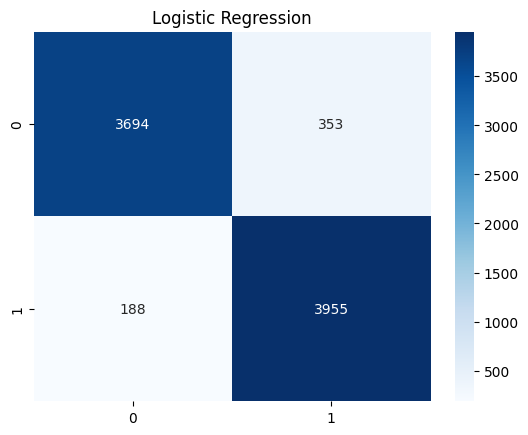

Training Random Forest...
Random Forest Accuracy: 0.9375
Random Forest F1-score: 0.9375
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4047
           1       0.93      0.95      0.94      4143

    accuracy                           0.94      8190
   macro avg       0.94      0.94      0.94      8190
weighted avg       0.94      0.94      0.94      8190



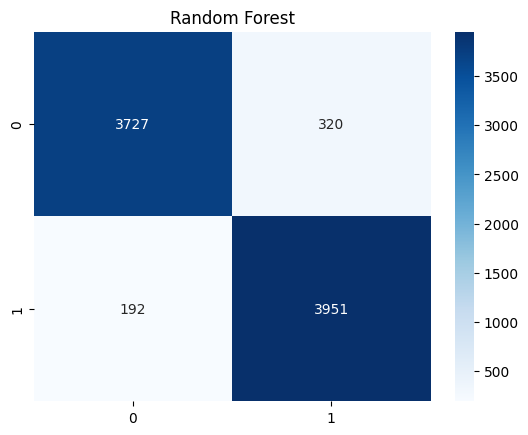

Training XGBoost...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9022
XGBoost F1-score: 0.9022
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4047
           1       0.90      0.90      0.90      4143

    accuracy                           0.90      8190
   macro avg       0.90      0.90      0.90      8190
weighted avg       0.90      0.90      0.90      8190



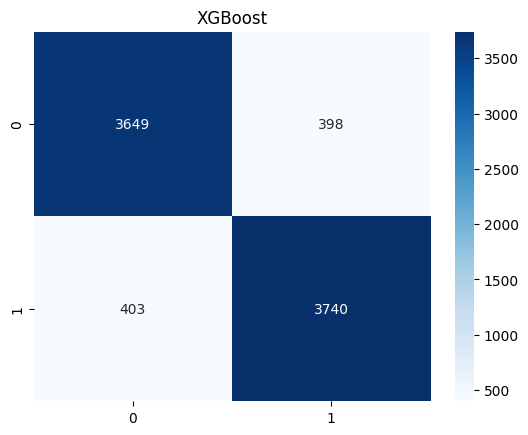

Training Neural Network...
Neural Network Accuracy: 0.9374
Neural Network F1-score: 0.9373
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4047
           1       0.92      0.96      0.94      4143

    accuracy                           0.94      8190
   macro avg       0.94      0.94      0.94      8190
weighted avg       0.94      0.94      0.94      8190



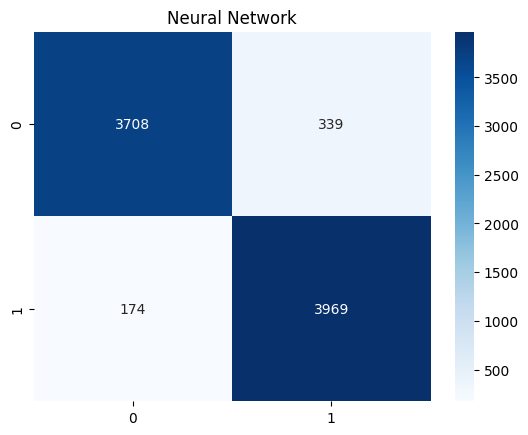

In [36]:
results = {}
for model_name, model in models.items():
    print(f'Training {model_name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[model_name] = acc_score
    print(f'{model_name} Accuracy: {acc_score:.4f}')
    print(f'{model_name} F1-score: {f1:.4f}')
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(model_name)
    plt.show()

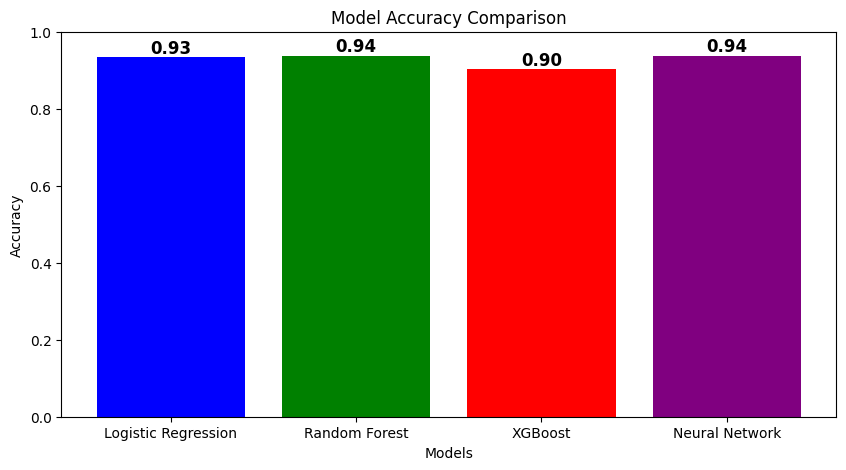

In [37]:
plt.figure(figsize=(10, 5))
acc_bars = plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
for bar in acc_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

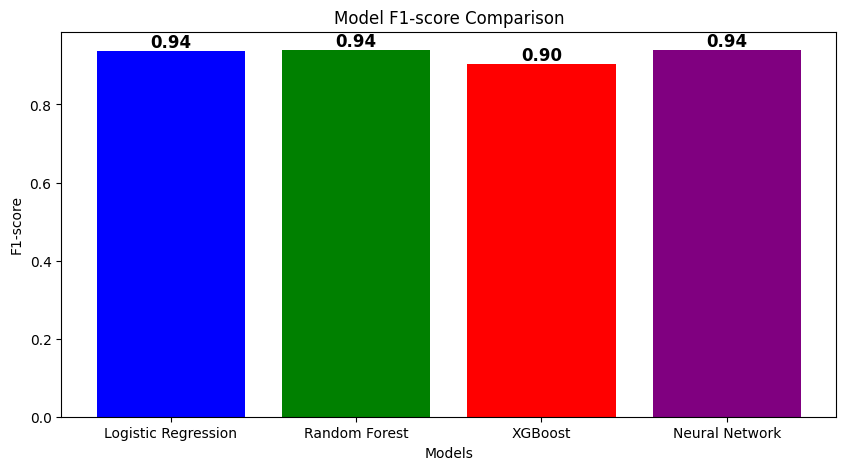

In [38]:
f1_scores = {model: f1_score(y_test, models[model].predict(X_test)) for model in models}
plt.figure(figsize=(10, 5))
f1_bars = plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'green', 'red', 'purple'])
for bar in f1_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.title('Model F1-score Comparison')
plt.show()

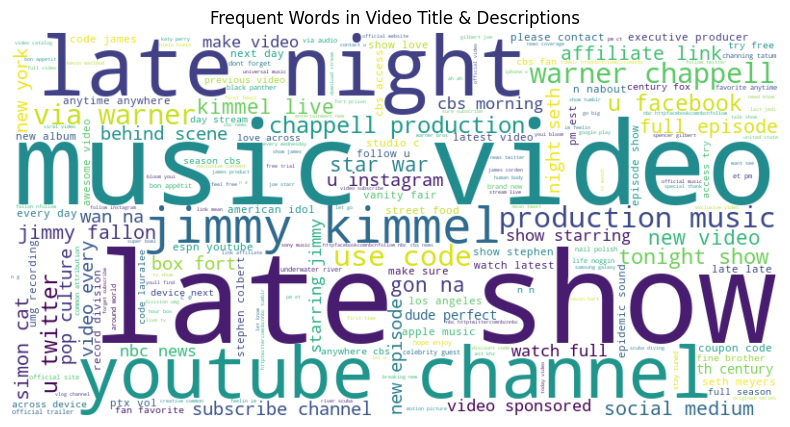

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['description_cleaned']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Frequent Words in Video Title & Descriptions")
plt.show()

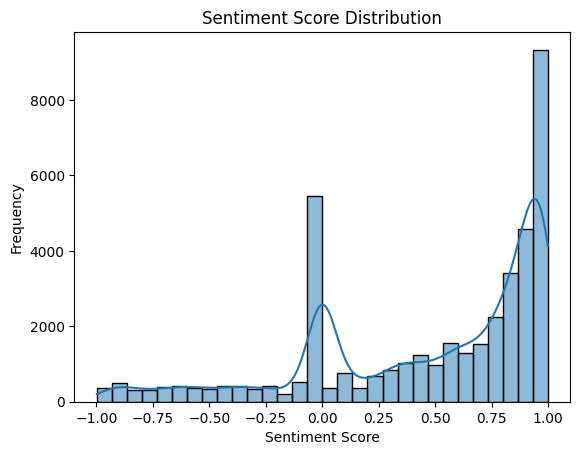

In [ ]:
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

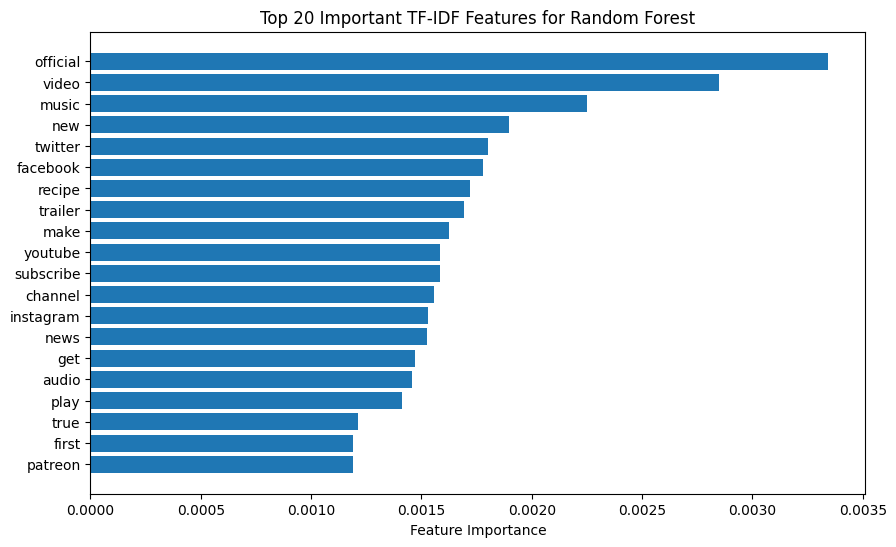

In [ ]:
rf_vimp = grid_rf.best_estimator_.feature_importances_
rf_vimp_tfidf = rf_vimp[:5000]
sorted_idx = np.argsort(rf_vimp_tfidf)[-20:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), rf_vimp_tfidf[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(tfidf_vectorizer.get_feature_names_out())[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important TF-IDF Features for Random Forest")
plt.show()